In [1]:
# Importing libraries
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import pathlib
import warnings
import os
import shutil
import glob
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
def dataframe_extract_data(dataframe,spot_type_selected = 0, minimal_cluster_size=3):
    ''' This function is intended to read a dataframe and returns 
        number_of_spots_per_cell, number_of_spots_per_cell_cytosol, number_of_spots_per_cell_nucleus, number_of_TS_per_cell, ts_size, cell_size
    '''
    number_cells = dataframe['cell_id'].nunique()
    # Number of spots
    number_of_spots_per_cell = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i)  & (dataframe['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)])
    # Number of spots in cytosol
    number_of_spots_per_cell_cytosol = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['is_nuc']==False) & (dataframe['spot_type']==spot_type_selected) ].spot_id) for i in range(0, number_cells)])
    # Number of spots in nucleus
    number_of_spots_per_cell_nucleus = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) &  (dataframe['is_cluster']==False) & (dataframe['is_nuc']==True) & (dataframe['spot_type']==spot_type_selected)    ].spot_id) for i in range(0, number_cells)])
    # Number of TS per cell.
    number_of_TS_per_cell = [len( dataframe.loc[  (dataframe['cell_id']==i) &  (dataframe['is_cluster']==True) & (dataframe['is_nuc']==True) & (dataframe['spot_type']==spot_type_selected) & (dataframe['cluster_size'] >=4) ].spot_id) for i in range(0, number_cells)]
    number_of_TS_per_cell= np.asarray(number_of_TS_per_cell)
    #number_of_TS_per_cell=number_of_TS_per_cell[number_of_TS_per_cell>minimal_cluster_size]   
    # Number of RNA in a TS
    ts_size =  dataframe.loc[   (dataframe['is_cluster']==True) & (dataframe['is_nuc']==True)  & (dataframe['spot_type']==spot_type_selected)   ].cluster_size.values
    # Size of each cell
    cell_size = np.asarray([len( dataframe.loc[  (dataframe['cell_id']==i) & (dataframe['spot_type']==0)].cell_area_px.values) for i in range(0, number_cells)])

    return number_of_spots_per_cell,number_of_spots_per_cell_cytosol,number_of_spots_per_cell_nucleus,number_of_TS_per_cell,ts_size,cell_size,number_cells


In [3]:
def unnesting(df, explode):
    # https://stackoverflow.com/a/53218939/14672920
    idx = df.index.repeat(df[explode[0]].str.len())
    df1 = pd.concat([
        pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
    df1.index = idx
    return df1.join(df.drop(explode, 1), how='left')

In [4]:
current_dir = pathlib.Path().absolute()

data_dir =['analysis_GAPDH-Cy3_NFKBIA-Cy5_woDex___nuc_120__cyto_220__psfz_350__psfyx_120',
            'analysis_GAPDH-Cy3_NFKBIA-Cy5_5min_100nMDex___nuc_120__cyto_220__psfz_350__psfyx_120',
            'analysis_GAPDH-Cy3_NFKBIA-Cy5_10min_100nMDex___nuc_120__cyto_220__psfz_350__psfyx_120',
            'analysis_GAPDH-Cy3_NFKBIA-Cy5_15min_100nMDex___nuc_120__cyto_220__psfz_350__psfyx_120',
            'analysis_GAPDH-Cy3_NFKBIA-Cy5_30min_100nMDex___nuc_120__cyto_220__psfz_350__psfyx_120',
            'analysis_GAPDH-Cy3_NFKBIA-Cy5_1h_100nMDex___nuc_120__cyto_220__psfz_350__psfyx_120',
            'analysis_GAPDH-Cy3_NFKBIA-Cy5_2h_100nMDex___nuc_120__cyto_220__psfz_350__psfyx_120',
            'analysis_GAPDH-Cy3_NFKBIA-Cy5_4h_100nMDex___nuc_120__cyto_220__psfz_350__psfyx_120']


In [5]:
list_spots_cell_conditions=[]
list_spots_nuc=[]
list_number_cells =[]

for i in range (0, len (data_dir)):
    dataframe_dir = current_dir.joinpath(data_dir[i])
    dataframe_file = glob.glob( str(dataframe_dir.joinpath('dataframe_*')) )[0]
    dataframe_file
    df = pd.read_csv(dataframe_file) 
    number_of_spots_per_cell,number_of_spots_per_cell_cytosol,number_of_spots_per_cell_nucleus,number_of_TS_per_cell,ts_size,cell_size,number_cells = dataframe_extract_data(df)
    list_spots_cell_conditions.append(number_of_spots_per_cell_cytosol)
    list_spots_nuc.append(number_of_spots_per_cell_nucleus)
    list_number_cells.append(number_cells)
    del number_of_spots_per_cell,number_of_spots_per_cell_cytosol,number_of_spots_per_cell_nucleus,number_of_TS_per_cell,ts_size,cell_size,number_cells


In [6]:
print('number of cells in each dataset: ', list_number_cells)

number of cells in each dataset:  [373, 327, 343, 332, 340, 333, 331, 299]


In [7]:
df_complete = pd.DataFrame({
    'condition': ['wo', '5min','10min','15min','30min','1h', '2h','4h']
})
df_complete['number_spots'] = list_spots_cell_conditions 
df_complete= unnesting(df_complete,['number_spots'])


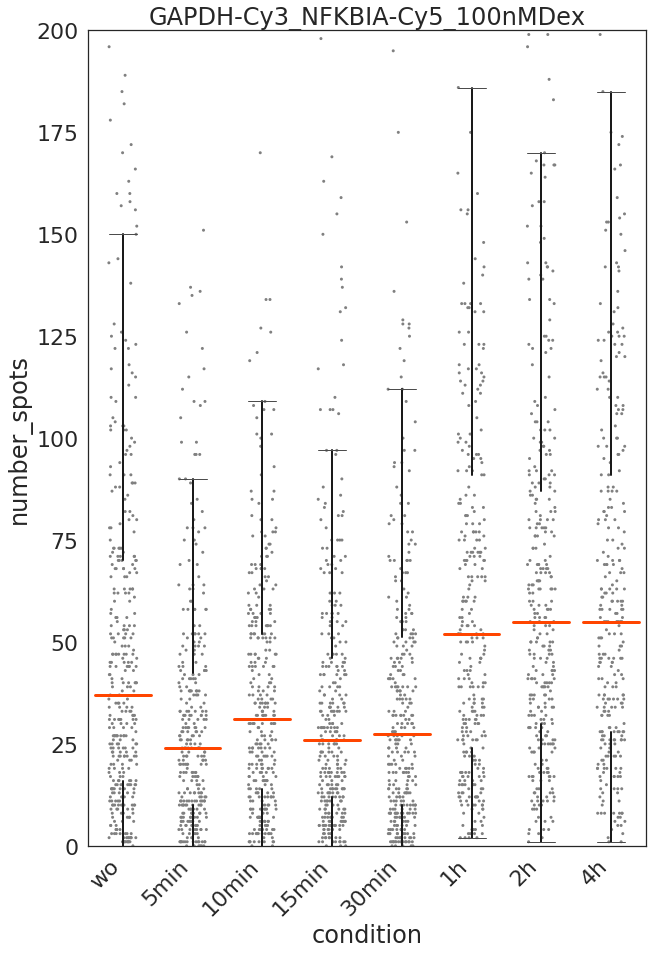

In [41]:
plt.figure(figsize=(10,15))
sns.set_style("white")
p = sns.stripplot(x="condition", y="number_spots", data=df_complete, size=3, color='0.5', jitter=0.2)
plt.xticks(rotation=45, ha="right")
sns.set(font_scale = 2)
p.set_xlabel("Conditions")
p.set_ylabel("Spot Count")
p.set_title("GAPDH-Cy3_NFKBIA-Cy5_100nMDex")
p.set_ylim(0,200)
# plot the mean line
bp=sns.boxplot(showmeans=False,meanline=False,zorder=10,showfliers=False,showbox=False,linewidth=1,color='b',
            #meanprops={'visible': False,'color': 'orangered', 'ls': 'solid', 'lw': 3},
            medianprops={'visible': True,'color': 'orangered', 'ls': 'solid', 'lw': 3},
            whiskerprops={'visible': True, 'color':'k','ls': 'solid', 'lw': 2},
            x="condition",
            y="number_spots",
            data=df_complete,
            showcaps={'visible': False, 'color':'orangered', 'ls': 'solid', 'lw': 1}, # Q1-Q3 25-75%
            ax=p)
#plt.title(title, size=16)
#plt.legend(labels=["Legend_Day1","Legend_Day2"])
plt.show()

